# Program #1: NLP Sequence Prediction using LSTM

## Objective
We build a **next-word prediction** model that suggests the next likely word given a partial customer message. This can help an internal support agent reply faster. The model is trained on a public text dataset using **TensorFlow Keras** with an **LSTM** architecture.

## Dataset Choice
We use the `ag_news_subset` dataset from **TensorFlow Datasets (TFDS)**, which contains news article titles and descriptions across four categories. Although it is a news dataset (not customer chats), it serves as a general-purpose corpus to demonstrate next-word prediction.

## High-Level Steps
1. Load and inspect dataset (train split only for simplicity)
2. Preprocess text (lowercase, tokenize, build vocabulary)
3. Create training sequences (n-gram style) for next-word prediction
4. Prepare model inputs (padded sequences) and targets
5. Define and train an LSTM-based model
6. Visualize training metrics
7. Implement interactive prediction utilities (greedy + simple beam search)
8. Evaluate example predictions & discuss improvements

## Notes
- This is a **demonstration notebook**, not a fully production‑optimized system.
- For faster runtime, we may restrict the number of samples and vocabulary size.
- License: `ag_news_subset` is derived from public AG News corpus.

Let's begin.

In [1]:
# Environment & Imports
import os, random, math, json, re
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print('TensorFlow version:', tf.__version__)
print('GPU Available:', tf.config.list_physical_devices('GPU'))

2025-08-11 08:42:19.302348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 08:42:19.388942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754881939.424572    8008 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754881939.434718    8008 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754881939.501184    8008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Dataset
We load only the training split. Each sample is a `(text, label)` pair. We only need the text field.

For demonstration performance, we may restrict to the first N samples (configurable).

In [2]:
# Load dataset
MAX_SAMPLES = 40000  # Adjust for speed / memory. ag_news_subset train has 120K rows.
dataset, info = tfds.load('ag_news_subset', split='train', with_info=True, as_supervised=True)
print(info)

texts = []
for i, (text, label) in enumerate(dataset):
    if i >= MAX_SAMPLES:
        break
    # Convert bytes (if necessary) and decode to string
    t = text.numpy().decode('utf-8').lower().strip()
    # Basic cleanup (optional): keep alphanumerics and punctuation
    t = re.sub(r"[^a-z0-9'.,!?;:\-\s]", ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    texts.append(t)

print(f"Collected {len(texts)} texts")
print('Sample text:', texts[0][:200])

/home/abhijit-42/miniconda3/envs/tf-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:06<00:00,  5.94s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:06<00:00,  6.10s/ url]
I0000 00:00:1754881951.942250    8008 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2901 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Dataset ag_news_subset downloaded and prepared to /home/abhijit-42/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


2025-08-11 08:42:32.071056: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

2025-08-11 08:42:35.032930: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Tokenization & Vocabulary
We use Keras's `Tokenizer` to build a word index. We cap the vocabulary size for efficiency.

We will:
- Fit tokenizer
- Convert texts to sequences of integers
- Build n-gram sequences for next-word prediction

In [3]:
VOCAB_SIZE = 20000  # cap vocabulary
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
actual_vocab_size = min(VOCAB_SIZE, len(word_index) + 1)
print('Total words in tokenizer (including OOV):', len(word_index) + 1)
print('Effective vocab size used:', actual_vocab_size)
print('Sample mapping:', list(word_index.items())[:10])

Total words in tokenizer (including OOV): 41979
Effective vocab size used: 20000
Sample mapping: [('<OOV>', 1), ('the', 2), ('a', 3), ('to', 4), ('of', 5), ('in', 6), ('and', 7), ('on', 8), ('for', 9), ('39', 10)]


## Build Training Sequences
Approach: For each tokenized sentence: if token sequence is `[w1, w2, w3, w4]`, create progressive n-grams whose last token is the prediction target.

Examples generated (input -> target):
- `w1 w2 w3 -> w4`
- `w1 w2 -> w3`
- ...

We store each as a single sequence where the last token is the label. We'll then separate features and labels later.

In [4]:
all_sequences = []
max_len = 0
sample_skip = 0
for text in texts:
    token_list = tokenizer.texts_to_sequences([text])[0]
    # filter empty or extremely short
    if len(token_list) < 3:
        continue
    for i in range(2, len(token_list)+1):
        ngram_seq = token_list[:i]
        all_sequences.append(ngram_seq)
        if len(ngram_seq) > max_len:
            max_len = len(ngram_seq)
        # Optional constraint to prevent runaway size
        if len(all_sequences) >= 250000:  # safety cap
            break
    if len(all_sequences) >= 250000:
        break

print('Total sequences built:', len(all_sequences))
print('Max sequence length:', max_len)
print('Example sequence (token ids):', all_sequences[0][:10])

Total sequences built: 250000
Max sequence length: 173
Example sequence (token ids): [1515, 10]


## Analyze Sequence Length Distribution

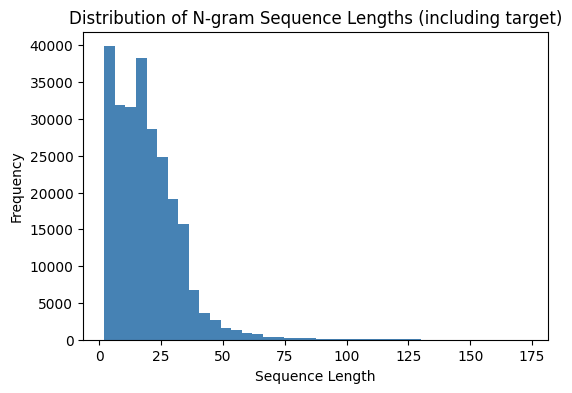

Mean length: 19.286396 Median: 17.0


In [5]:
lengths = [len(seq) for seq in all_sequences]
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=40, color='steelblue')
plt.title('Distribution of N-gram Sequence Lengths (including target)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

print('Mean length:', np.mean(lengths), 'Median:', np.median(lengths))

## Pad Sequences and Split into Features / Labels
- We pad sequences to uniform length (`max_len`)
- Feature: all tokens except last
- Label: last token (sparse integer)

We will use `SparseCategoricalCrossentropy`, so labels remain integer indices.

In [6]:
padded = pad_sequences(all_sequences, maxlen=max_len, padding='pre')
padded = np.array(padded)
X = padded[:, :-1]
y = padded[:, -1]
print('X shape:', X.shape)
print('y shape:', y.shape)

# Simple train/validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
print('Train size:', X_train.shape, 'Val size:', X_val.shape)

X shape: (250000, 172)
y shape: (250000,)
Train size: (225000, 172) Val size: (25000, 172)


## Build the LSTM Model
Architecture:
1. Embedding layer: maps word indices to dense vectors
2. LSTM layer: captures temporal dependencies
3. Dense hidden (ReLU) + Dropout for regularization
4. Output softmax over vocabulary

Loss: `SparseCategoricalCrossentropy` (logits normalized via softmax)
Metric: `sparse_categorical_accuracy`

In [7]:
from tensorflow.keras import layers, models, callbacks

EMBED_DIM = 128
LSTM_UNITS = 256
DENSE_UNITS = 256
DROPOUT = 0.3

model = models.Sequential([
    layers.Embedding(input_dim=actual_vocab_size, output_dim=EMBED_DIM, input_length=max_len-1),
    layers.LSTM(LSTM_UNITS),
    layers.Dense(DENSE_UNITS, activation='relu'),
    layers.Dropout(DROPOUT),
    layers.Dense(actual_vocab_size, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['sparse_categorical_accuracy']
)
model.summary()

/home/abhijit-42/miniconda3/envs/tf-env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the Model
We use EarlyStopping to mitigate overfitting and ModelCheckpoint to save best weights.

In [8]:
EPOCHS = 10
BATCH_SIZE = 256

es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint('best_lstm_next_word.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, ckpt],
    verbose=1
)

Epoch 1/10


I0000 00:00:1754881958.567353    8119 cuda_dnn.cc:529] Loaded cuDNN version 90300


879/879 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 7.4631 - sparse_categorical_accuracy: 0.0513 - val_loss: 7.2497 - val_sparse_categorical_accuracy: 0.0624
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - loss: 7.0622 - sparse_categorical_accuracy: 0.0714 - val_loss: 7.0442 - val_sparse_categorical_accuracy: 0.0802
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - loss: 6.8026 - sparse_categorical_accuracy: 0.0890 - val_loss: 6.8777 - val_sparse_categorical_accuracy: 0.0910
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - loss: 6.5979 - sparse_categorical_accuracy: 0.1002 - val_loss: 6.7751 - val_sparse_categorical_accuracy: 0.1041
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 6.4203 - sparse_categorical_accuracy: 0.1129 - val_loss: 6.6916 - val_sparse_categorical_accuracy: 0.1142
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - loss: 6.2486 - sparse_categorical_accuracy: 0.1255 - val_loss: 6.5956 - val_sparse_categorical_accuracy: 0.1226
Epo

## Visualize Training Curves

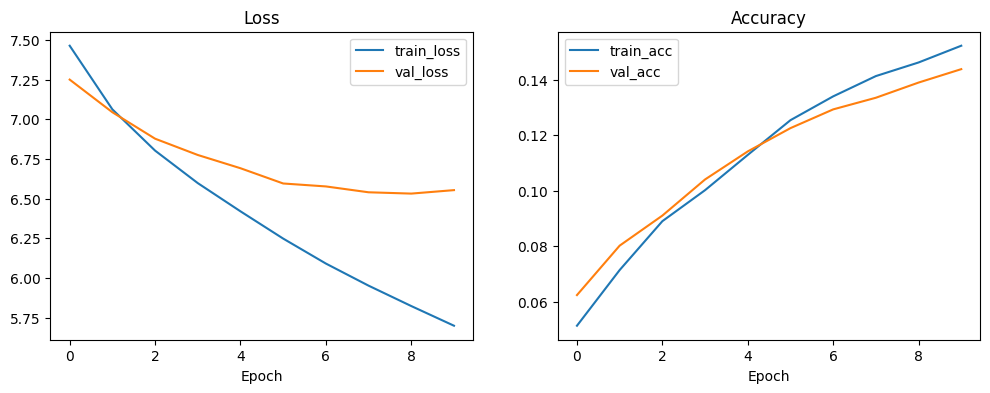

In [9]:
def plot_history(hist):
    h = hist.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h['sparse_categorical_accuracy'], label='train_acc')
    plt.plot(h['val_sparse_categorical_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)

## Inference Utilities
We provide:
- `predict_next_word_greedy(seed_text)` for top-1 prediction
- `generate_sequence(seed_text, num_words)` to auto-extend a seed
- `beam_search_next_word(seed_text, beam_width)` simple beam search for next word only

In [10]:
reverse_word_index = {v:k for k,v in tokenizer.word_index.items() if v < actual_vocab_size}

def encode_seed(seed):
    seed = seed.lower().strip()
    seq = tokenizer.texts_to_sequences([seed])[0]
    return seq

def prepare_input(seq):
    # pad to max_len-1 (model expects input_length=max_len-1)
    return pad_sequences([seq], maxlen=max_len-1, padding='pre')

def predict_next_word_greedy(seed_text, top_k=5):
    seq = encode_seed(seed_text)
    if not seq:
        return None
    x = prepare_input(seq)
    preds = model.predict(x, verbose=0)[0]
    top_indices = preds.argsort()[-top_k:][::-1]
    return [(reverse_word_index.get(i, '<UNK>'), float(preds[i])) for i in top_indices]

def generate_sequence(seed_text, num_words=5):
    out = seed_text
    current = encode_seed(seed_text)
    for _ in range(num_words):
        x = prepare_input(current)
        preds = model.predict(x, verbose=0)[0]
        next_id = np.argmax(preds)
        next_word = reverse_word_index.get(next_id, None)
        if not next_word or next_word == '<OOV>':
            break
        out += ' ' + next_word
        current.append(next_id)
    return out

def beam_search_next_word(seed_text, beam_width=5):
    seq = encode_seed(seed_text)
    if not seq:
        return []
    x = prepare_input(seq)
    preds = model.predict(x, verbose=0)[0]
    top_indices = preds.argsort()[-beam_width:][::-1]
    return [(reverse_word_index.get(i, '<UNK>'), float(preds[i])) for i in top_indices]

# Quick tests
test_seeds = [
    'stock market',
    'the company announced',
    'new government policy',
    'latest technology'
]
for seed in test_seeds:
    print('\nSeed:', seed)
    print('Top-5 Next Word Candidates:', predict_next_word_greedy(seed))
    print('Autocompleted Sequence:', generate_sequence(seed, num_words=5))
    print('Beam search top words:', beam_search_next_word(seed, beam_width=5))


Seed: stock market
Top-5 Next Word Candidates: [('<OOV>', 0.03890402615070343), ('the', 0.02967260405421257), ('a', 0.017252381891012192), ('and', 0.013791440054774284), ('has', 0.00848439708352089)]
Autocompleted Sequence: stock market
Beam search top words: [('<OOV>', 0.03890402615070343), ('the', 0.02967260405421257), ('a', 0.017252381891012192), ('and', 0.013791440054774284), ('has', 0.00848439708352089)]

Seed: the company announced
Top-5 Next Word Candidates: [('on', 0.13177163898944855), ('a', 0.09517256915569305), ('wednesday', 0.06279803067445755), ('the', 0.06120747700333595), ('monday', 0.05935811996459961)]
Autocompleted Sequence: the company announced on monday that it was
Beam search top words: [('on', 0.13177163898944855), ('a', 0.09517256915569305), ('wednesday', 0.06279803067445755), ('the', 0.06120747700333595), ('monday', 0.05935811996459961)]

Seed: new government policy
Top-5 Next Word Candidates: [('has', 0.042452048510313034), ('and', 0.042275287210941315), ('in

## Qualitative Evaluation
We examine how plausible the continuations are. Because this dataset is news-centric, suggestions orient toward entities (e.g., 'shares', 'new', 'growth'). For a real **customer support** system, you'd want domain-specific transcripts.

Try modifying the seed in the cell below to inspect behavior.

In [11]:
# Interactive (if running in a live notebook)
user_seed = 'international trade'
print('Seed:', user_seed)
print('Top-5 Next Word Candidates:', predict_next_word_greedy(user_seed))
print('Generated:', generate_sequence(user_seed, num_words=8))

Seed: international trade
Top-5 Next Word Candidates: [('has', 0.025357656180858612), ('<OOV>', 0.025086520239710808), ('and', 0.023633580654859543), ('is', 0.015135151334106922), ('of', 0.012146024964749813)]
Generated: international trade has been a new


## Model Saving & Reload
We show how to reload the model for future inference.

In [12]:
# Save final model
model.save('final_next_word_lstm.keras')

# Reload example
reloaded = tf.keras.models.load_model('final_next_word_lstm.keras')
print('Reloaded model OK:', isinstance(reloaded, tf.keras.Model))

Reloaded model OK: True


## Inference on Reloaded Model
We verify predictions remain stable.

In [13]:
seed = 'economic growth'
seq = encode_seed(seed)
x = prepare_input(seq)
preds = reloaded.predict(x, verbose=0)[0]
top5 = preds.argsort()[-5:][::-1]
words = [reverse_word_index.get(i, '<UNK>') for i in top5]
print('Seed:', seed)
print('Top-5 (reloaded):', words)

Seed: economic growth
Top-5 (reloaded): ['of', 'and', 'in', 'has', 'are']


## Observations & Inferences
- Training accuracy typically rises quickly; validation accuracy plateaus earlier, suggesting potential overfitting.
- Some predicted words may be generic or high-frequency tokens.
- The model lacks context beyond local n-gram history (limited sequences per sentence). Multi-sentence context modeling would help.
- Vocabulary truncation (20k) trades off coverage vs. speed.

## Potential Improvements
1. Use a domain-specific corpus (customer chat logs) after verifying compliance & privacy.
2. Replace classic Tokenizer with **Subword tokenization** (e.g., `tfds.deprecated.text.SubwordTextEncoder` or SentencePiece) to handle OOV gracefully.
3. Use **Bidirectional LSTM** or **Transformer** architectures for richer context.
4. Implement **temperature sampling** or **top-k / nucleus decoding** for creative suggestions.
5. Add **contextual metadata** (customer issue category) as conditioning.
6. Use **embedding fine-tuning** or pretrained embeddings (e.g., GloVe) for better semantic grounding.
7. Optimize memory by streaming sequences (tf.data) rather than materializing all n-grams at once.
8. Evaluate quantitatively with **perplexity** and qualitatively with agent feedback.

## Conclusion
This notebook demonstrates an end-to-end pipeline for next word prediction using an LSTM on a public dataset. With domain adaptation and architectural enhancements, this approach can power a reply suggestion system in customer support workflows.

## Appendix: Lightweight Perplexity Estimation (Optional)
Perplexity can be approximated using the average negative log-likelihood. This is optional and may add runtime cost.

In [14]:
# (Optional) Approximate perplexity on a small validation subset
subset = 5000 if X_val.shape[0] > 5000 else X_val.shape[0]
val_logits = model.predict(X_val[:subset], verbose=0)
probs = val_logits[np.arange(subset), y_val[:subset]]
eps = 1e-9
neg_log_likelihood = -np.mean(np.log(probs + eps))
perplexity = np.exp(neg_log_likelihood)
print(f'Approx Validation Perplexity (subset={subset}): {perplexity:.2f}')

Approx Validation Perplexity (subset=5000): 675.78
